In [1]:
import os
os.environ["JAVA_HOME"] = "/usr"

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("Select 'spark' as hello ")

df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/26 23:30:37 WARN Utils: Your hostname, Corei9-13900K-64GB, resolves to a loopback address: 127.0.1.1; using 143.107.145.69 instead (on interface enp3s0)
25/07/26 23:30:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/26 23:30:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/26 23:30:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/26 23:30:37 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


+-----+
|hello|
+-----+
|spark|
+-----+



In [3]:
df = spark.read.csv("../data/raw/Base.csv", header=True, inferSchema=True)
df.show()

+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+------------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_month

25/07/26 23:30:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
df.printSchema()

root
 |-- fraud_bool: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- name_email_similarity: double (nullable = true)
 |-- prev_address_months_count: integer (nullable = true)
 |-- current_address_months_count: integer (nullable = true)
 |-- customer_age: integer (nullable = true)
 |-- days_since_request: double (nullable = true)
 |-- intended_balcon_amount: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- zip_count_4w: integer (nullable = true)
 |-- velocity_6h: double (nullable = true)
 |-- velocity_24h: double (nullable = true)
 |-- velocity_4w: double (nullable = true)
 |-- bank_branch_count_8w: integer (nullable = true)
 |-- date_of_birth_distinct_emails_4w: integer (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_risk_score: integer (nullable = true)
 |-- email_is_free: integer (nullable = true)
 |-- housing_status: string (nullable = true)
 |-- phone_home_valid: integer (nullable = true)
 |-- phone_mobil

In [5]:
df.describe().show()

+-------+-----------------+-------------------+---------------------+-------------------------+----------------------------+-----------------+--------------------+----------------------+------------+------------------+-------------------+------------------+-----------------+--------------------+--------------------------------+-----------------+-----------------+------------------+--------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------+-------------------------+---------+-------------------+-------------------------+------------------+------------------+
|summary|       fraud_bool|             income|name_email_similarity|prev_address_months_count|current_address_months_count|     customer_age|  days_since_request|intended_balcon_amount|payment_type|      zip_count_4w|        velocity_6h|      velocity_24h|      velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credi

32 columns, of which 5 are categorical, 7 are binary and 20 are numeric.

The dataset was created to benchmark classification models in tabular data. It is a synthetic dataset generated by a GAN model. It might not have any actual meaning, but it might be a good practice for data visualization, statistical tests and machine learning development.

The data refers to bank account creation data. Each sample represent data about the request to create a bank account.

More information about the dataset may be found [here](https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf).

In [6]:
df.count()

1000000

1M samples

In [7]:
from pyspark.sql.functions import when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+-----------+------------+-----------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+------+-------------------------+---------+------------------+-------------------------+------------------+-----+
|fraud_bool|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|velocity_6h|velocity_24h|velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|proposed_credit_limit|foreign_request|sour

No null values in any of the columns

In [8]:
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType

numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]
numeric_df = df.select(*numeric_columns)

numeric_df.select([count(when(col(c) < 0, c)).alias(c) for c in numeric_df.columns]).show()

+----------+------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+-----------+------------+-----------+--------------------+--------------------------------+-----------------+-------------+----------------+------------------+-----------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+------------------+-----+
|fraud_bool|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|zip_count_4w|velocity_6h|velocity_24h|velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_cards|proposed_credit_limit|foreign_request|session_length_in_minutes|keep_alive_session|device_distinct_emails_8w|device_fraud_count|month|
+----------+----

Negative values represent missing values. Columns prev_address_months_count and intended_balcon_amount had most of the samples with missing values.  Column bank_months_count had a considerable amount of missing values.

In [9]:
df.select("device_fraud_count").describe().show()

+-------+------------------+
|summary|device_fraud_count|
+-------+------------------+
|  count|           1000000|
|   mean|               0.0|
| stddev|               0.0|
|    min|                 0|
|    max|                 0|
+-------+------------------+



In [10]:
device_fraud_counts = df.groupBy("device_fraud_count").count().orderBy("count", ascending=False)
device_fraud_counts.show()

+------------------+-------+
|device_fraud_count|  count|
+------------------+-------+
|                 0|1000000|
+------------------+-------+



All values are the same.

We will drop this column to avoid using it in later steps

In [11]:
df = df.drop("device_fraud_count")

### Categorical columns distribution

In [12]:
state_counts = df.groupBy("payment_type").count().orderBy("count", ascending=False)
state_counts.show()
state_counts.plot.bar(x="payment_type", y="count", title="Payment Type Counts") 

+------------+------+
|payment_type| count|
+------------+------+
|          AB|370554|
|          AA|258249|
|          AC|252071|
|          AD|118837|
|          AE|   289|
+------------+------+



The payment_type column is extremely unbalanced. The acronyms are not explained in the datasheet and most likely don't mean anything.

In [13]:
bb_counts = df.groupBy("housing_status").count().orderBy("count", ascending=False)
bb_counts.show()
bb_counts.plot.bar(x="housing_status", y="count", title="Housing Status Counts")

+--------------+------+
|housing_status| count|
+--------------+------+
|            BC|372143|
|            BB|260965|
|            BA|169675|
|            BE|169135|
|            BD| 26161|
|            BF|  1669|
|            BG|   252|
+--------------+------+



The housing_status column is extremely unbalanced.

In [14]:
city_counts = df.groupBy("employment_status").count().orderBy("count", ascending=False)
city_counts.show()
city_counts.plot.bar(x="employment_status", y="count", title="Employment Status Counts")

+-----------------+------+
|employment_status| count|
+-----------------+------+
|               CA|730252|
|               CB|138288|
|               CF| 44034|
|               CC| 37758|
|               CD| 26522|
|               CE| 22693|
|               CG|   453|
+-----------------+------+



The employment_status column is extremely unbalanced.

In [15]:
at_counts = df.groupBy("source").count().orderBy("count", ascending=False)
at_counts.show()
at_counts.plot.bar(x="source", y="count", title="Source Counts")

+--------+------+
|  source| count|
+--------+------+
|INTERNET|992952|
| TELEAPP|  7048|
+--------+------+



The source column is extremely unbalanced. "INTERNET" means the request was made through the intert, while "TELEAPP" represent requests made by an app.

In [16]:
mc_counts = df.groupBy("device_os").count().orderBy("count", ascending=False)
mc_counts.show()
mc_counts.plot.bar(x="device_os", y="count", title="Device OS Counts")

+---------+------+
|device_os| count|
+---------+------+
|    other|342728|
|    linux|332712|
|  windows|263506|
|macintosh| 53826|
|      x11|  7228|
+---------+------+



The device_os column is extremely unbalanced. Possible values are: Windows, macOS (macintosh), Linux, X11, or other. Most of the devices had "other" OSs.

Most of the categorical data was extremely unbalanced towards some classes.

### Numeric columns distribution

Numeric columns:
- income
- name_email_similarity
- prev_address_months_count
- current_address_months_count
- customer_age
- days_since_request
- intended_balcon_amount
- zip_count_4w
- velocity_6h
- velocity_24h
- velocity_4w
- bank_branch_count_8w
- date_of_birth_distinct_emails_4w
- credit_risk_score
- bank_months_count
- proposed_credit_limit
- session_length_in_minutes
- device_distinct_emails
- month

In [17]:
df.plot.hist(column="income", bins=5, title="Income Distribution")

25/07/26 23:30:47 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:47 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:47 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Income follows a biomodal distribution

In [18]:
df.plot.hist(column="name_email_similarity", bins=30, title="Name-Email Similarity Distribution")

25/07/26 23:30:47 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:47 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:48 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Name-Email Similarity follows a trimodal distribution with peaks in the 0.11, o.5 and 0.75 values.

In [19]:
positive_previous_address = df.filter(df.prev_address_months_count >= 0)

positive_previous_address.plot.hist(column="prev_address_months_count", bins=10, title="Previous Address In Months Distribution")

25/07/26 23:30:48 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:48 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:48 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Previous Address in Months have a right skewed distribution. A lot of the samples have "-1" as the value, which represents a missing information.

In [20]:
positive_current_address = df.filter(df.current_address_months_count >= 0)

positive_current_address.plot.hist(column="current_address_months_count", bins=10, title="Current Address In Months Distribution")

25/07/26 23:30:48 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:49 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:49 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Current Address in Months have a right skewed distribution. A lot of the samples have "-1" as the value, which represents a missing information.

In [21]:
df.plot.hist(column="customer_age", bins=8, title="Customer Age Distribution")

25/07/26 23:30:49 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:49 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:49 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Customer age have a right skewed distribution. 

In [22]:
df.plot.hist(column="days_since_request", bins=8, title="Days Since Request Distribution")

25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed distribution

In [23]:
positive_intended_balcon = df.filter(df.intended_balcon_amount >= 0)
positive_intended_balcon.plot.hist(column="intended_balcon_amount", bins=20, title="Intended Balcon Amount Distribution")

25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:50 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Trimodal distribution.

In [24]:
negative_intended_balcon = df.filter(df.intended_balcon_amount < 0)
negative_intended_balcon.plot.hist(column="intended_balcon_amount", bins=16, title="Missing Values of Intended Balcon Amount Distribution")

25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Therefore, most of the values are negative, close to between -2 and 0.

In [25]:
df.plot.hist(column="zip_count_4w", bins=20, title="Same Zip Address Requests in the Last 4 Weeks Distribution")

25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:51 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed distribution

In [26]:
positive_velocity_6 = df.filter(df.velocity_6h >= 0)
positive_velocity_6.plot.hist(column="velocity_6h", bins=20, title="Velocity in the Last 6 Hours Distribution")

25/07/26 23:30:52 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:52 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:52 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed distribution

In [27]:
positive_velocity_24 = df.filter(df.velocity_24h >= 0)
positive_velocity_24.plot.hist(column="velocity_24h", bins=200, title="Velocity in the Last 24 Hours Distribution")

25/07/26 23:30:52 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:52 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:53 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Multimodal distribution with a slight skew to the right

In [28]:
positive_velocity_4w = df.filter(df.velocity_4w >= 0)
positive_velocity_4w.plot.hist(column="velocity_4w", bins=200, title="Velocity in the Last 4 Weeks Distribution")

25/07/26 23:30:53 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:53 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Multi-modal distribution with plenty of peaks

In [29]:
positive_bank_branch = df.filter(df.bank_branch_count_8w >= 0)
positive_bank_branch.plot.hist(column="bank_branch_count_8w", bins=10, title="Bank Branch Applications in Last 8 Weeks")

25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


most of the values are in the 0-238 bin

In [30]:
positive_dob_emails = df.filter(df.date_of_birth_distinct_emails_4w >= 0)
positive_dob_emails.plot.hist(column="date_of_birth_distinct_emails_4w", bins=20, title="Emails with Same DOB in Last 4 Weeks")

25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:54 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:55 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed normal distribution

In [31]:
positive_credit_score = df.filter(df.credit_risk_score >= 0)
positive_credit_score.plot.hist(column="credit_risk_score", bins=20, title="Credit Risk Score Distribution")

25/07/26 23:30:55 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:55 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:55 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed normal distribution

In [32]:
valid_bank_months = df.filter(df.bank_months_count >= 0)  # Filtering out -1 (missing values)
valid_bank_months.plot.hist(column="bank_months_count", bins=20, title="Bank Account Age in Months")

25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Multi-modal distribution

In [33]:
df.plot.hist(column="proposed_credit_limit", bins=4, title="Proposed Credit Limit Distribution")

25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Most of the values fall in the 190-667.5 bin

In [34]:
valid_session_length = df.filter(df.session_length_in_minutes >= 0)  # Filtering out -1 (missing values)
valid_session_length.plot.hist(column="session_length_in_minutes", bins=20, title="Session Length in Minutes")

25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:56 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:57 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Right skewed distribution

In [35]:
df.plot.hist(column="month", bins=7, title="Application Month Distribution")

25/07/26 23:30:57 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:57 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:57 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Uniform distribution, with about 130k per bin, with a peak of 205k for month 7

In [36]:
email_counts = df.groupBy("device_distinct_emails_8w").count().orderBy("count", ascending=False)
email_counts.show()
df.plot.hist(column="device_distinct_emails_8w", bins=4, title="Device Distinct Emails in the Last 8 Weeks Distribution")

+-------------------------+------+
|device_distinct_emails_8w| count|
+-------------------------+------+
|                        1|968067|
|                        2| 25302|
|                        0|  6272|
|                       -1|   359|
+-------------------------+------+



25/07/26 23:30:58 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:58 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.
25/07/26 23:30:58 WARN HintErrorLogger: Hint (strategy=broadcast) is not supported in the query: build left for left outer join.


Heavily unbalanced data.

We can conclude that none of the numeric columns follow a normal distribution.

### Binary Columns Distribution

In [37]:
from pyspark.sql.functions import when

binary_processed = df

# Mapping binary columns to descriptive labels
binary_processed = binary_processed.withColumn("email_is_free", 
                   when(binary_processed.email_is_free == 1, "Free").otherwise("Paid"))

binary_processed = binary_processed.withColumn("phone_home_valid", 
                   when(binary_processed.phone_home_valid == 1, "Valid").otherwise("Invalid"))

binary_processed = binary_processed.withColumn("phone_mobile_valid", 
                   when(binary_processed.phone_mobile_valid == 1, "Valid").otherwise("Invalid"))

binary_processed = binary_processed.withColumn("has_other_cards", 
                   when(binary_processed.has_other_cards == 1, "Yes").otherwise("No"))

binary_processed = binary_processed.withColumn("foreign_request", 
                   when(binary_processed.foreign_request == 1, "Foreign").otherwise("Domestic"))

binary_processed = binary_processed.withColumn("keep_alive_session", 
                   when(binary_processed.keep_alive_session == 1, "Enabled").otherwise("Disabled"))

binary_processed = binary_processed.withColumn("fraud_bool", 
                   when(binary_processed.fraud_bool == 1, "Fraud").otherwise("Non-Fraud"))

binary_processed.show(5)


+----------+------------------+---------------------+-------------------------+----------------------------+------------+------------------+----------------------+------------+------------+------------------+-----------------+------------------+--------------------+--------------------------------+-----------------+-----------------+-------------+--------------+----------------+------------------+-----------------+---------------+---------------------+---------------+--------+-------------------------+---------+------------------+-------------------------+-----+
|fraud_bool|            income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|days_since_request|intended_balcon_amount|payment_type|zip_count_4w|       velocity_6h|     velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|employment_status|credit_risk_score|email_is_free|housing_status|phone_home_valid|phone_mobile_valid|bank_months_count|has_other_car

In [38]:
email_counts = binary_processed.groupBy("email_is_free").count().orderBy("count", ascending=False)
email_counts.show()
email_counts.plot.bar(x="email_is_free", y="count", title="Email Type Counts")

+-------------+------+
|email_is_free| count|
+-------------+------+
|         Free|529886|
|         Paid|470114|
+-------------+------+



Slightly unbalanced.

In [39]:
phone_home_counts = binary_processed.groupBy("phone_home_valid").count().orderBy("count", ascending=False)
phone_home_counts.show()
phone_home_counts.plot.bar(x="phone_home_valid", y="count", title="Home Phone Validity Counts")

+----------------+------+
|phone_home_valid| count|
+----------------+------+
|         Invalid|582923|
|           Valid|417077|
+----------------+------+



Unbalanced.

In [40]:
phone_mobile_counts = binary_processed.groupBy("phone_mobile_valid").count().orderBy("count", ascending=False)
phone_mobile_counts.show()
phone_mobile_counts.plot.bar(x="phone_mobile_valid", y="count", title="Mobile Phone Validity Counts")

+------------------+------+
|phone_mobile_valid| count|
+------------------+------+
|             Valid|889676|
|           Invalid|110324|
+------------------+------+



Extremely unbalanced.

In [41]:
cards_counts = binary_processed.groupBy("has_other_cards").count().orderBy("count", ascending=False)
cards_counts.show()
cards_counts.plot.bar(x="has_other_cards", y="count", title="Other Cards Ownership Counts")

+---------------+------+
|has_other_cards| count|
+---------------+------+
|             No|777012|
|            Yes|222988|
+---------------+------+



Extremely unbalanced.

In [42]:
foreign_counts = binary_processed.groupBy("foreign_request").count().orderBy("count", ascending=False)
foreign_counts.show()
foreign_counts.plot.bar(x="foreign_request", y="count", title="Request Origin Counts")

+---------------+------+
|foreign_request| count|
+---------------+------+
|       Domestic|974758|
|        Foreign| 25242|
+---------------+------+



Extremely unbalanced.

In [43]:
keep_alive_counts = binary_processed.groupBy("keep_alive_session").count().orderBy("count", ascending=False)
keep_alive_counts.show()
keep_alive_counts.plot.bar(x="keep_alive_session", y="count", title="Keep Alive Session Status Counts")

+------------------+------+
|keep_alive_session| count|
+------------------+------+
|           Enabled|576947|
|          Disabled|423053|
+------------------+------+



Slightly unbalanced

In [44]:
fraud_counts = binary_processed.groupBy("fraud_bool").count().orderBy("count", ascending=False)
fraud_counts.show()
fraud_counts.plot.bar(x="fraud_bool", y="count", title="Fraud Detection Counts")

+----------+------+
|fraud_bool| count|
+----------+------+
| Non-Fraud|988971|
|     Fraud| 11029|
+----------+------+



Extremely unbalanced

### Correlation Analysis

In [45]:
from pathlib import Path

FIG_PATH = Path("../reports/figures/EDA")
FIG_PATH.mkdir(parents=True, exist_ok=True)

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sample = df.sample(fraction=0.1, seed=42)
pdf = sample.toPandas()
pdf

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,0,0.8,0.153880,-1,103,40,0.045122,-1.101184,AB,1548,...,25,1,200.0,0,INTERNET,11.234264,other,1,1,0
1,0,0.8,0.122370,-1,20,30,0.023472,-0.881640,AD,1655,...,30,0,200.0,0,INTERNET,7.836945,windows,1,1,0
2,0,0.2,0.527751,13,114,20,0.003171,-0.848347,AB,4389,...,15,0,200.0,0,INTERNET,2.838194,windows,1,2,0
3,0,0.4,0.060003,-1,55,20,0.023319,-0.640623,AB,1234,...,1,0,200.0,0,INTERNET,5.793523,linux,1,1,0
4,0,0.1,0.410949,-1,110,20,0.032962,29.312614,AA,736,...,25,0,200.0,0,INTERNET,2.310008,macintosh,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100191,0,0.8,0.883767,-1,175,50,0.032510,-0.714696,AD,779,...,10,0,1000.0,0,INTERNET,3.012195,other,1,1,7
100192,0,0.9,0.048815,-1,147,30,0.015713,-1.133400,AB,828,...,11,0,200.0,0,INTERNET,5.562196,other,1,1,7
100193,0,0.1,0.404750,52,6,30,0.006297,-1.286384,AB,1780,...,28,0,200.0,0,INTERNET,5.150834,linux,0,1,7
100194,0,0.1,0.276843,164,32,10,0.015371,-1.023581,AB,463,...,28,0,200.0,0,INTERNET,3.744430,other,1,1,7


In [47]:
cols_to_drop = [
    # Categorical
    'payment_type', 'employment_status', 'housing_status', 'source', 'device_os',
    # Binary
    'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 
    'has_other_cards', 'foreign_request', 'keep_alive_session',
]

numeric_columns = pdf.drop(columns=cols_to_drop)
numeric_columns.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
       'credit_risk_score', 'bank_months_count', 'proposed_credit_limit',
       'session_length_in_minutes', 'device_distinct_emails_8w', 'month'],
      dtype='object')

In [48]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_pdf = numeric_columns.select_dtypes(include=numerics)
correlation_matrix = numeric_pdf.corr(method='pearson')
correlation_matrix

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,bank_months_count,proposed_credit_limit,session_length_in_minutes,device_distinct_emails_8w,month
fraud_bool,1.000000,0.045452,-0.032706,-0.026645,0.032314,0.064120,0.000644,-0.027861,0.003594,-0.021188,-0.013378,-0.011025,-0.013058,-0.043848,0.070498,-0.002781,0.068549,0.013872,0.035165,0.013881
income,0.045452,1.000000,-0.039027,0.015264,-0.037501,0.123764,-0.023097,0.058360,-0.078011,-0.102766,-0.105749,-0.104012,0.005037,-0.064777,0.171859,-0.004801,0.110429,-0.050488,-0.010938,0.114616
name_email_similarity,-0.032706,-0.039027,1.000000,-0.016278,0.045990,-0.045987,-0.004090,0.030262,0.028609,0.026625,0.039730,0.039470,-0.009629,0.024529,0.046107,-0.004390,0.074297,0.006772,-0.016661,-0.043954
prev_address_months_count,-0.026645,0.015264,-0.016278,1.000000,-0.270060,-0.073235,0.075590,-0.009487,-0.031681,-0.004098,0.007733,0.004976,-0.040798,0.062081,-0.016080,-0.051527,-0.027418,0.048432,0.009191,-0.002310
current_address_months_count,0.032314,-0.037501,0.045990,-0.270060,1.000000,0.147490,-0.050435,0.056527,0.050838,0.028926,0.020862,0.026180,0.054857,-0.173614,0.094756,0.072141,0.131948,-0.038410,0.000873,-0.023533
customer_age,0.064120,0.123764,-0.045987,-0.073235,0.147490,1.000000,-0.034667,-0.013057,-0.013882,-0.024111,-0.011563,-0.005339,0.047309,-0.418614,0.165370,0.009273,0.148796,0.021329,0.027488,0.005527
days_since_request,0.000644,-0.023097,-0.004090,0.075590,-0.050435,-0.034667,1.000000,0.016931,0.003119,0.033047,0.027762,0.018952,-0.018559,0.016824,-0.093877,-0.029784,-0.070716,0.053172,0.010465,-0.020957
intended_balcon_amount,-0.027861,0.058360,0.030262,-0.009487,0.056527,-0.013057,0.016931,1.000000,0.001884,0.044357,0.065330,0.053717,0.105084,-0.031859,-0.000477,0.170841,0.058454,0.023223,-0.023313,-0.047919
zip_count_4w,0.003594,-0.078011,0.028609,-0.031681,0.050838,-0.013882,0.003119,0.001884,1.000000,0.143027,0.200907,0.299561,0.006189,0.120931,-0.096829,0.045445,-0.010922,0.043534,0.015218,-0.283398
velocity_6h,-0.021188,-0.102766,0.026625,-0.004098,0.028926,-0.024111,0.033047,0.044357,0.143027,1.000000,0.463227,0.399276,0.020579,0.117625,-0.142342,0.007995,-0.028829,0.054081,0.030744,-0.406369


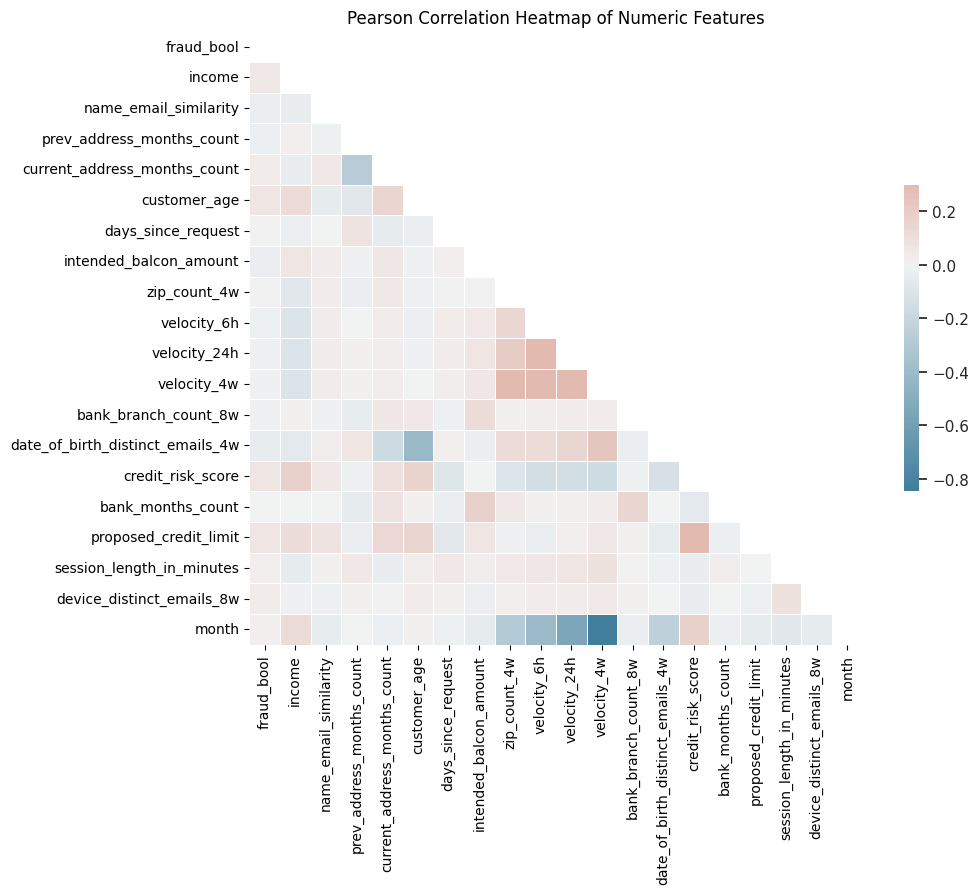

In [49]:
import numpy as np

correlation_matrix = numeric_pdf.corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set_theme(style="darkgrid")
plt.title("Pearson Correlation Heatmap of Numeric Features")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
CORR_FIG_PATH = FIG_PATH / "corr"
CORR_FIG_PATH.mkdir(parents=True, exist_ok=True)

plt.tight_layout()
plt.savefig(CORR_FIG_PATH / "pearson_correlation_heatmap.png", bbox_inches='tight')
plt.show()

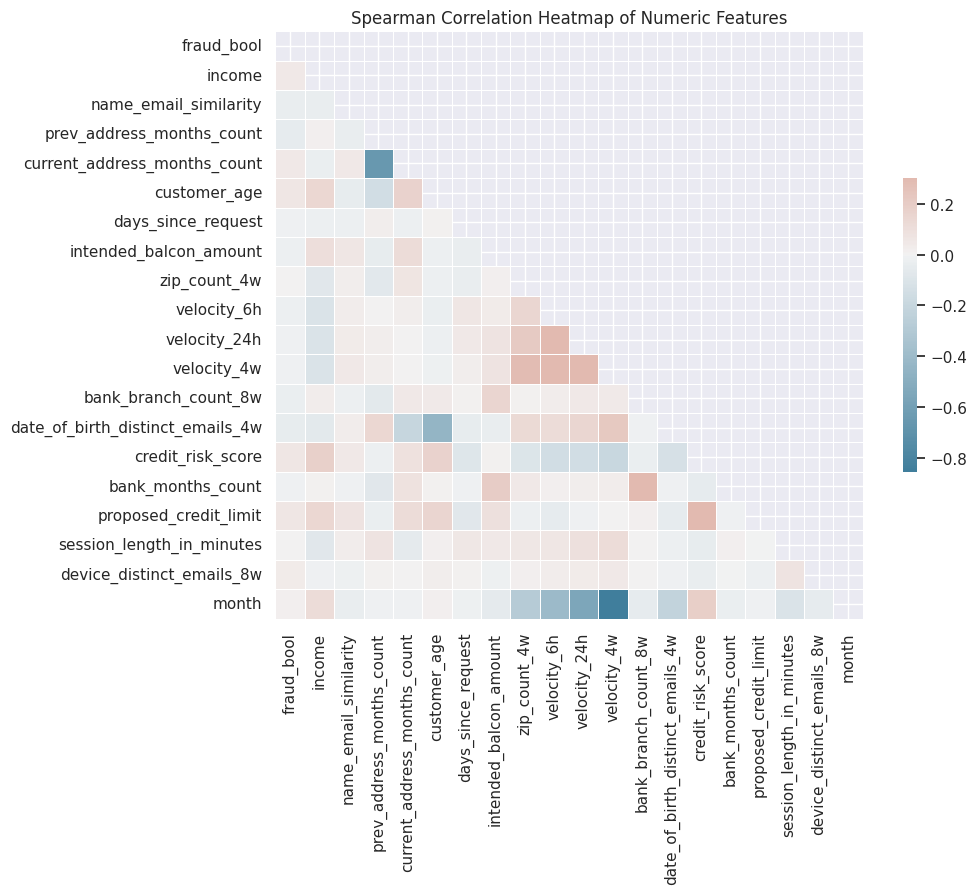

In [50]:
import numpy as np


correlation_matrix = numeric_pdf.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set_theme(style="darkgrid")
plt.title("Spearman Correlation Heatmap of Numeric Features")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig(CORR_FIG_PATH / "spearman_correlation_heatmap.png", bbox_inches='tight')
plt.show()

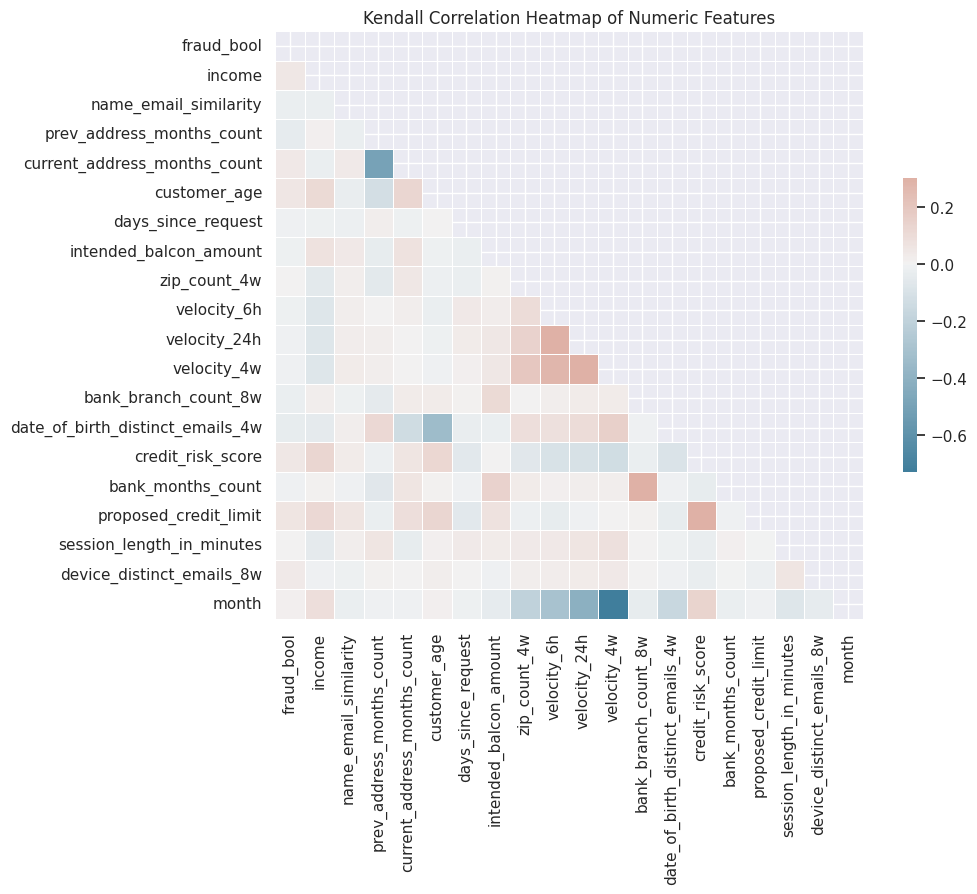

In [51]:
import numpy as np


correlation_matrix = numeric_pdf.corr(method='kendall')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set_theme(style="darkgrid")
plt.title("Kendall Correlation Heatmap of Numeric Features")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.savefig(CORR_FIG_PATH / "kendall_correlation_heatmap.png", bbox_inches='tight')
plt.show()

Most of the derived features related to the same variable (eg. velocity_6h and velocity_24h) had a negative correlation against each other.

The velocity variables had a positive correlation related to the month, indicating that in later months more requests are made.

Age had a positive  correlation with the number of emails of applicants of the same date of birth. This is an interesting correlation.

Credit risk score and proposed credit limit had a negative correlation. This indicates that people with a lower credit score tend to ask for more credit.

The age of the previous ban account is negatively correlated to the number of requests for the same bank branch in the last 8 weeks.

Current and previous address in months is positively correlated. indicating that people tend to move between addresses fast, or tend to stay longer in their addresses

### Fraud vs Numeric columns

In [52]:
sample = df.sample(fraction=0.1, seed=42)
pdf = sample.toPandas()

In [53]:
pdf["fraud_bool"].value_counts()

fraud_bool
0    99119
1     1077
Name: count, dtype: int64

Fraudulent accounts are unbalanced.

In [54]:
fraud_counts = df.groupBy("fraud_bool").count().orderBy("count", ascending=False)
fraud_counts.show()

+----------+------+
|fraud_bool| count|
+----------+------+
|         0|988971|
|         1| 11029|
+----------+------+



In [55]:
fraud_counts = fraud_counts.toPandas()
non_fraud_count = fraud_counts[fraud_counts["fraud_bool"] == 0]["count"].values[0]
fraud_counts = fraud_counts[fraud_counts["fraud_bool"] == 1]["count"].values[0]

In [56]:
sample_size = fraud_counts / 2

fraud_account_pct = sample_size / fraud_counts
# sample size porcentage of fraud accounts
print(fraud_account_pct)

# sample size porcentage of non-fraud accounts
non_fraud_pct = sample_size / non_fraud_count
print(non_fraud_pct)

0.5
0.005575997678395019


In [57]:
fraudulent_df = df.filter(df.fraud_bool == 1).sample(fraud_account_pct, seed=42).toPandas()
fraudulent_df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
count,5515.0,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,...,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000,5515.000000
mean,1.0,0.682520,0.392155,6.135630,113.408341,40.826836,1.017004,3.970027,1617.410698,5163.985493,...,0.253128,0.850227,10.692294,0.084134,837.109701,0.052221,8.301607,0.341976,1.081958,3.557933
std,0.0,0.268161,0.294295,34.131115,84.142876,13.223818,5.514594,16.296529,1002.418225,2892.003884,...,0.434843,0.356881,12.946647,0.277614,642.430963,0.222493,9.853216,0.474415,0.318956,2.323191
min,1.0,0.100000,0.000412,-1.000000,-1.000000,10.000000,0.000008,-8.249792,45.000000,161.665123,...,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,1.0,0.500000,0.132913,-1.000000,53.000000,30.000000,0.005971,-1.201530,913.500000,2873.285830,...,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.258826,0.000000,1.000000,2.000000
50%,1.0,0.800000,0.295335,-1.000000,93.000000,40.000000,0.013221,-0.901686,1320.000000,4925.396640,...,0.000000,1.000000,2.000000,0.000000,500.000000,0.000000,5.116672,0.000000,1.000000,4.000000
75%,1.0,0.900000,0.669222,-1.000000,154.000000,50.000000,0.023404,-0.555836,2024.500000,7076.915870,...,1.000000,1.000000,25.000000,0.000000,1500.000000,0.000000,8.563872,1.000000,1.000000,6.000000
max,1.0,0.900000,0.999942,357.000000,388.000000,90.000000,74.868828,109.830290,6368.000000,16084.617170,...,1.000000,1.000000,31.000000,1.000000,2100.000000,1.000000,77.730242,1.000000,2.000000,7.000000


In [58]:
non_fraudulent_df = df.filter(df.fraud_bool == 0).sample(non_fraud_pct, seed=42).toPandas()
non_fraudulent_df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
count,5434.0,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,...,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000,5434.000000
mean,0.0,0.556367,0.489147,16.034045,85.749172,33.629003,0.937001,8.853518,1572.472028,5663.944740,...,0.418660,0.891056,10.680714,0.228377,511.306588,0.023003,7.481382,0.575451,1.016010,3.277512
std,0.0,0.292361,0.288767,42.155145,87.996439,12.041985,4.915221,20.705150,996.289486,2995.710143,...,0.493385,0.311597,12.090622,0.419825,485.131765,0.149928,7.808665,0.494320,0.175641,2.199573
min,0.0,0.100000,0.000170,-1.000000,-1.000000,10.000000,0.000003,-8.518085,5.000000,122.066267,...,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,0.0,0.300000,0.221629,-1.000000,18.250000,20.000000,0.007296,-1.182541,895.000000,3467.508328,...,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.161275,0.000000,1.000000,1.000000
50%,0.0,0.600000,0.487157,-1.000000,53.000000,30.000000,0.015447,-0.835470,1267.000000,5294.276807,...,0.000000,1.000000,5.000000,0.000000,200.000000,0.000000,5.131183,1.000000,1.000000,3.000000
75%,0.0,0.800000,0.752902,12.000000,128.000000,40.000000,0.026499,5.440699,1976.000000,7690.771174,...,1.000000,1.000000,25.000000,0.000000,500.000000,0.000000,8.769906,1.000000,1.000000,5.000000
max,0.0,0.900000,0.999999,342.000000,394.000000,80.000000,72.503201,110.501639,6294.000000,16556.028555,...,1.000000,1.000000,31.000000,1.000000,2000.000000,1.000000,76.768622,1.000000,2.000000,7.000000


In [59]:
import pandas as pd
sampled_dataset = pd.concat([fraudulent_df, non_fraudulent_df], ignore_index=True)
sampled_dataset.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month
count,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,...,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.000000,10949.00000
mean,0.503699,0.619910,0.440292,11.048224,99.681067,37.254544,0.977299,6.393709,1595.107590,5412.115783,...,0.335282,0.870490,10.686547,0.155722,675.413280,0.037720,7.894528,0.457850,1.049228,3.41876
std,0.500009,0.287427,0.295557,38.640541,87.177015,13.152487,5.225640,18.774110,999.588165,2954.390692,...,0.472110,0.335778,12.528543,0.362608,592.620961,0.190528,8.906465,0.498243,0.260067,2.26692
min,0.000000,0.100000,0.000170,-1.000000,-1.000000,10.000000,0.000003,-8.518085,5.000000,122.066267,...,0.000000,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.00000
25%,0.000000,0.400000,0.163076,-1.000000,35.000000,30.000000,0.006602,-1.192276,905.000000,3169.612007,...,0.000000,1.000000,-1.000000,0.000000,200.000000,0.000000,3.212978,0.000000,1.000000,1.00000
50%,1.000000,0.700000,0.398302,-1.000000,73.000000,40.000000,0.014229,-0.872081,1291.000000,5083.631343,...,0.000000,1.000000,3.000000,0.000000,200.000000,0.000000,5.126775,0.000000,1.000000,3.00000
75%,1.000000,0.900000,0.720550,-1.000000,143.000000,50.000000,0.025060,-0.445261,2004.000000,7410.439671,...,1.000000,1.000000,25.000000,0.000000,1500.000000,0.000000,8.639194,1.000000,1.000000,5.00000
max,1.000000,0.900000,0.999999,357.000000,394.000000,90.000000,74.868828,110.501639,6368.000000,16556.028555,...,1.000000,1.000000,31.000000,1.000000,2100.000000,1.000000,77.730242,1.000000,2.000000,7.00000


In [60]:
sampled_dataset

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,1,0.9,0.570800,-1,157,60,0.005908,35.337538,AA,4079,...,30,0,1500.0,0,INTERNET,4.036394,windows,1,1,0
1,1,0.1,0.993219,-1,67,20,0.015331,92.120139,AA,1192,...,25,0,1500.0,0,INTERNET,12.928072,windows,0,1,0
2,1,0.8,0.794351,-1,376,60,17.925951,41.422110,AA,815,...,28,0,1500.0,0,INTERNET,2.550167,linux,0,1,0
3,1,0.6,0.254250,-1,187,60,0.007115,-1.112033,AB,1040,...,4,0,1500.0,0,INTERNET,11.148815,windows,1,2,0
4,1,0.1,0.120051,-1,62,30,0.009814,48.951723,AA,2294,...,21,0,200.0,0,INTERNET,31.086788,other,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10944,0,0.7,0.903359,-1,142,40,0.020240,-0.825278,AB,808,...,2,0,200.0,0,INTERNET,2.776153,other,1,1,7
10945,0,0.4,0.484725,26,29,50,0.001274,29.548416,AA,696,...,10,0,200.0,0,INTERNET,1.410345,linux,0,1,7
10946,0,0.6,0.885078,87,10,40,0.007163,-0.875838,AC,111,...,-1,0,200.0,0,INTERNET,2.094177,linux,1,1,7
10947,0,0.7,0.140171,53,6,30,0.033440,-1.148283,AB,1001,...,1,0,500.0,0,INTERNET,2.282765,linux,1,1,7


In [61]:
sampled_dataset.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'month'],
      dtype='object')

In [62]:
# remaps is_fraud from 0 and 1 to non-fraud and fraud
sampled_dataset['fraud_bool'] = sampled_dataset['fraud_bool'].map({0: 'Non-Fraud', 1: 'Fraud'})

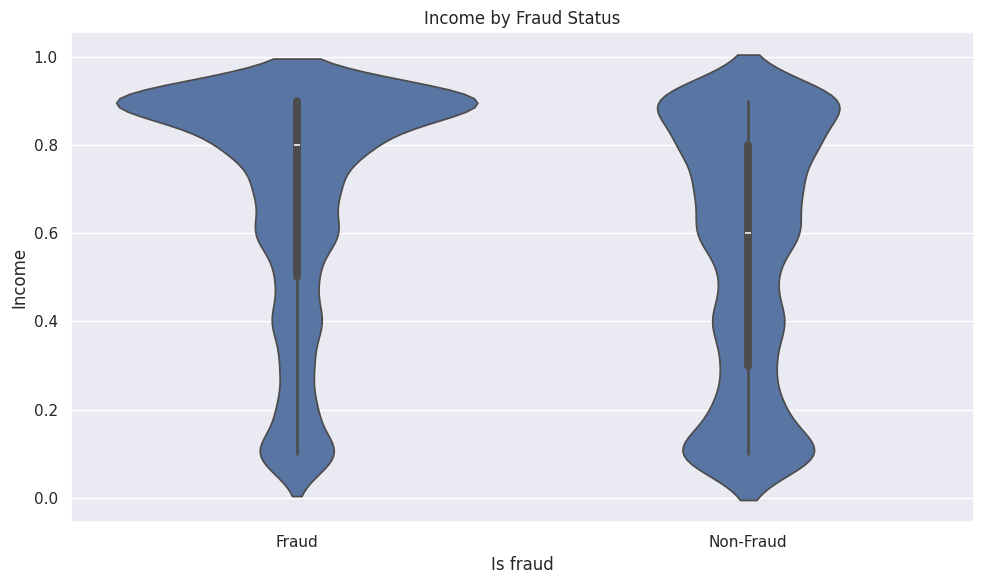

In [63]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
sns.violinplot(sampled_dataset, x="fraud_bool", y="income")
#sns.boxplot(data=sampled_dataset, x="fraud_bool", y="income")
plt.title("Income by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Income")
plt.tight_layout()
plt.savefig(FIG_PATH / "income_by_fraud_status.png")
plt.show()

Income is in decile. Fraudulent accounts have a higher mean income. Non fraudulent accounts have a lower mean.

Fraudulent accounts have a left skewed distribution. Non fraudulent have a bimodal distribution.

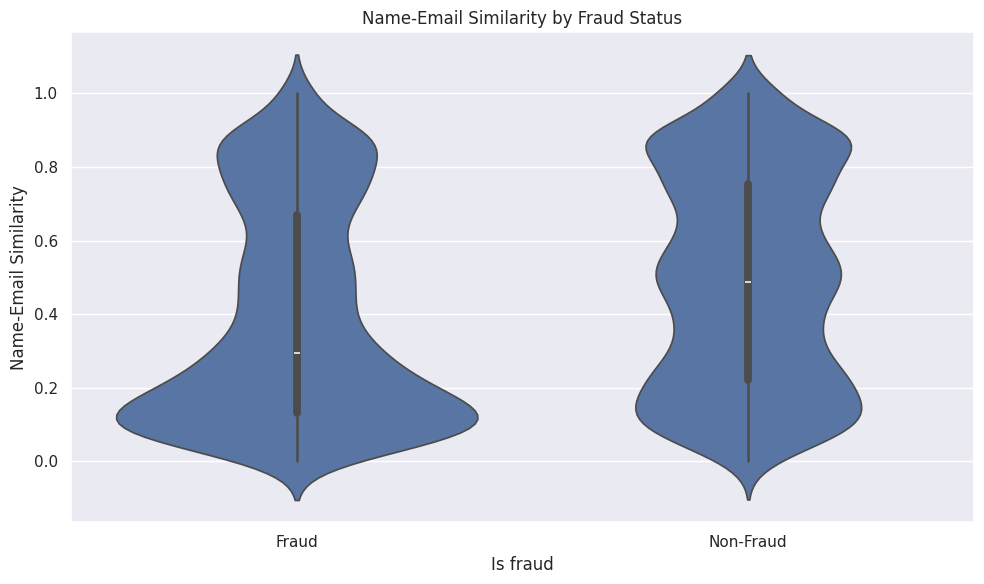

In [64]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="name_email_similarity")
plt.title("Name-Email Similarity by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Name-Email Similarity")
plt.tight_layout()
plt.savefig(FIG_PATH / "name_email_similarity_by_fraud_status.png")
plt.show()

Fraudulent accounts tend to use names and emails with lower similarity than common accounts

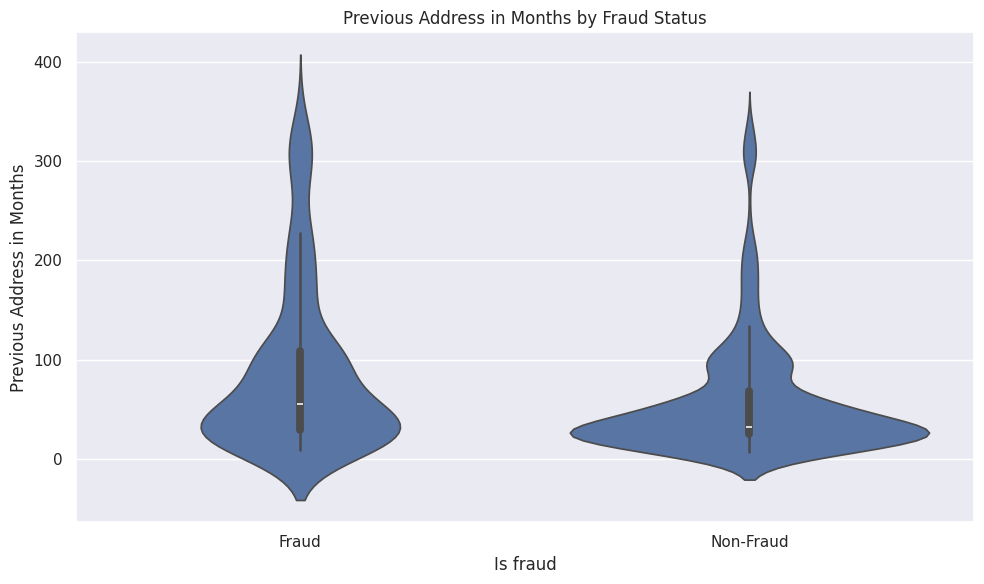

In [65]:
plt.figure(figsize=(10, 6))
positive_previous_address = sampled_dataset[sampled_dataset['prev_address_months_count'] >= 0]
sns.violinplot(positive_previous_address, x="fraud_bool", y="prev_address_months_count")
#sns.boxplot(data=positive_previous_address, x="fraud_bool", y="prev_address_months_count")
plt.title("Previous Address in Months by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Previous Address in Months")
plt.tight_layout()
plt.savefig(FIG_PATH / "previous_address_months_by_fraud_status.png")
plt.show()

Fraudulent accounts have a slightly higher mean amount of months on previous addresses than common accounts. Both groups have a right skewed distribution.

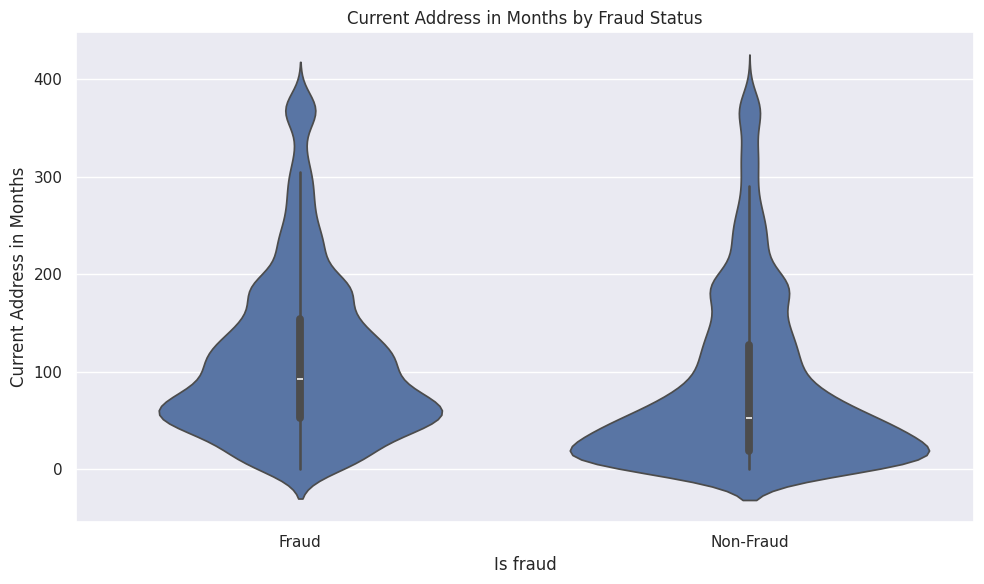

In [66]:
plt.figure(figsize=(10, 6))
positive_current_address = sampled_dataset[sampled_dataset['current_address_months_count'] >= 0]
sns.violinplot(positive_current_address, x="fraud_bool", y="current_address_months_count")
plt.title("Current Address in Months by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Current Address in Months")
plt.tight_layout()
plt.savefig(FIG_PATH / "current_address_months_by_fraud_status.png")
plt.show()

Higher mean for fraudulent accounts

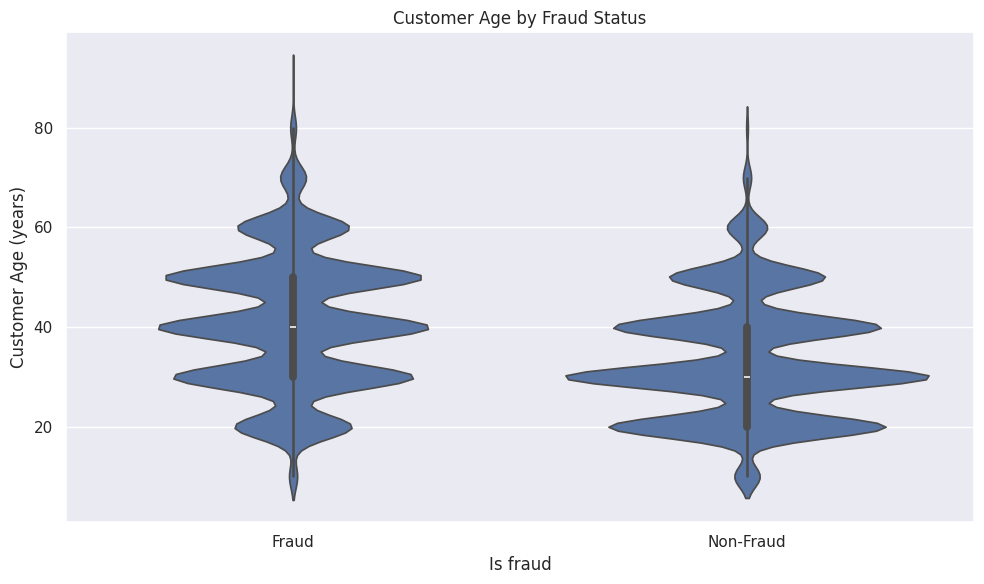

In [67]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="customer_age")
plt.title("Customer Age by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Customer Age (years)")
plt.tight_layout()
plt.savefig(FIG_PATH / "customer_age_by_fraud_status.png")
plt.show()

Fraudulent accounts tend to use an older age than common accounts.

In [68]:
sampled_dataset["days_since_request"].describe()

count    10949.000000
mean         0.977299
std          5.225640
min          0.000003
25%          0.006602
50%          0.014229
75%          0.025060
max         74.868828
Name: days_since_request, dtype: float64

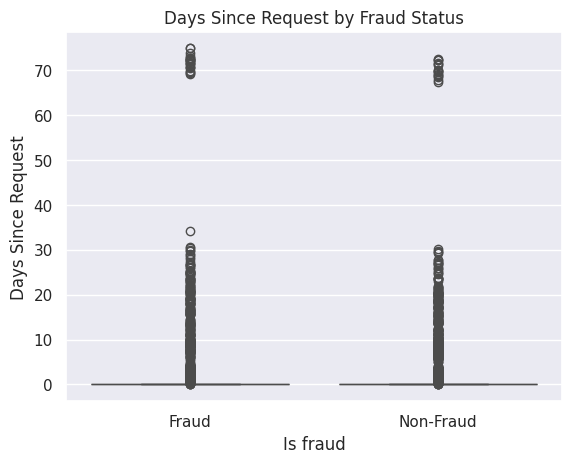

In [69]:
#sns.violinplot(sampled_dataset, x="fraud_bool", y="days_since_request")
sns.boxplot(sampled_dataset, x="fraud_bool", y="days_since_request")
plt.title("Days Since Request by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Days Since Request")
plt.show()

Data is too concentrated on small values, with a lot of outliers.

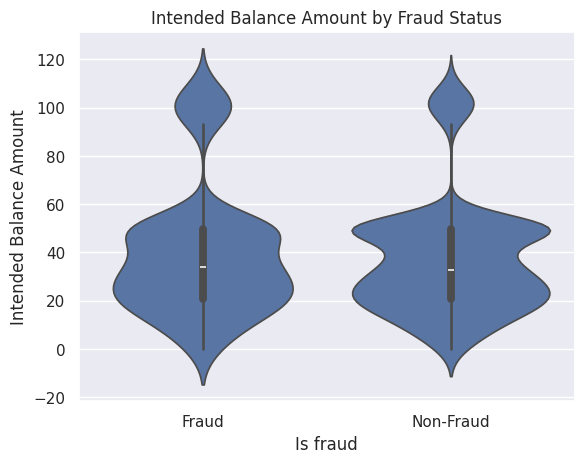

In [70]:
positive_intended = sampled_dataset[sampled_dataset['intended_balcon_amount'] >= 0]
sns.violinplot(positive_intended, x="fraud_bool", y="intended_balcon_amount")
plt.title("Intended Balance Amount by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Intended Balance Amount")
plt.show()

Means are the same, same distribution for both groups

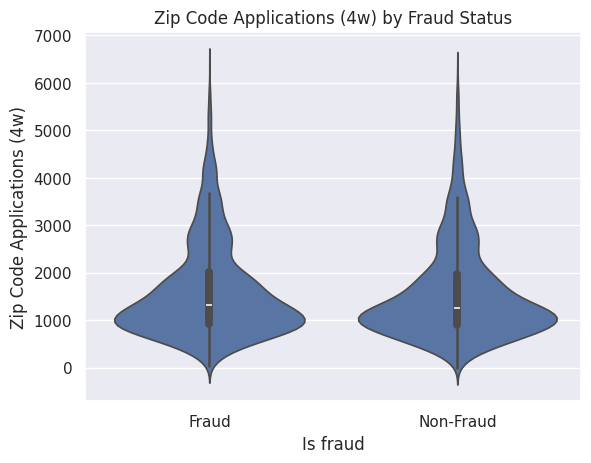

In [71]:
sns.violinplot(sampled_dataset, x="fraud_bool", y="zip_count_4w")
plt.title("Zip Code Applications (4w) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Zip Code Applications (4w)")
plt.show()

Means are the same, same distribution for both groups

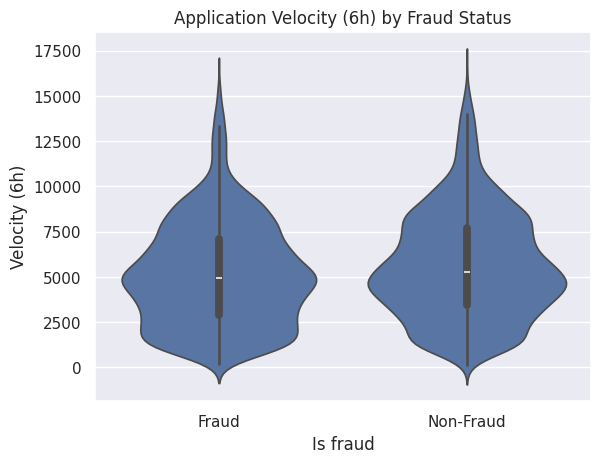

In [72]:
sns.violinplot(sampled_dataset, x="fraud_bool", y="velocity_6h")
plt.title("Application Velocity (6h) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Velocity (6h)")
plt.show()

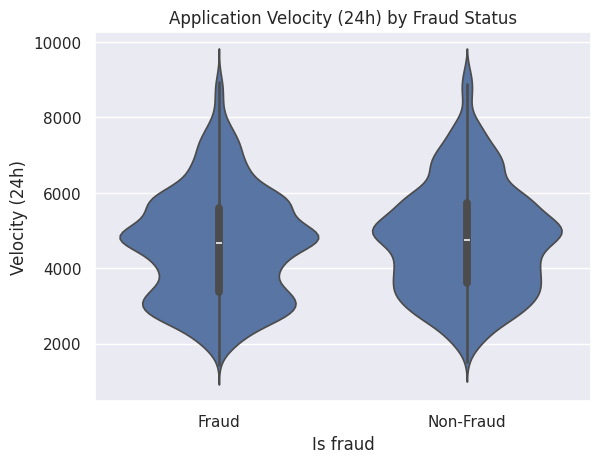

In [73]:
sns.violinplot(sampled_dataset, x="fraud_bool", y="velocity_24h")
plt.title("Application Velocity (24h) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Velocity (24h)")
plt.show()

Means are the same, almost the same distribution.

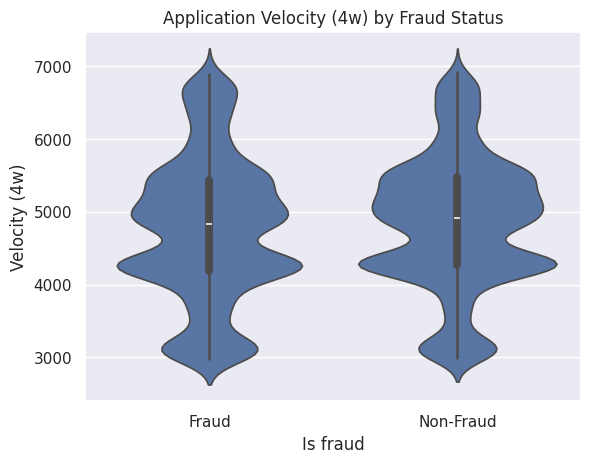

In [74]:
sns.violinplot(sampled_dataset, x="fraud_bool", y="velocity_4w")
plt.title("Application Velocity (4w) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Velocity (4w)")
plt.show()

Means are the same, so is the distribution

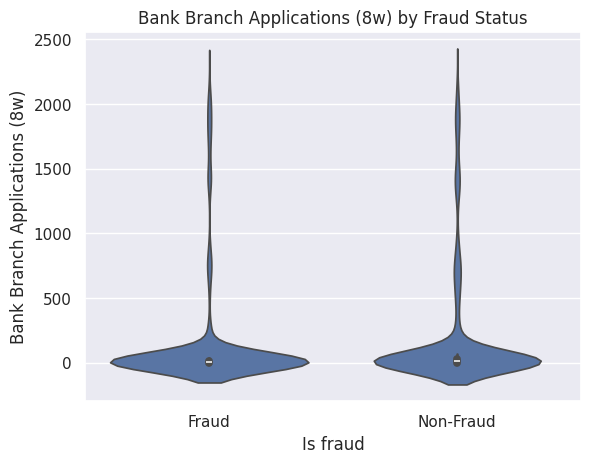

In [75]:
sns.violinplot(sampled_dataset, x="fraud_bool", y="bank_branch_count_8w")
plt.title("Bank Branch Applications (8w) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Bank Branch Applications (8w)")
plt.show()

In [76]:
sampled_dataset["bank_branch_count_8w"].describe()

count    10949.000000
mean       166.413645
std        450.306841
min          0.000000
25%          1.000000
50%          7.000000
75%         18.000000
max       2266.000000
Name: bank_branch_count_8w, dtype: float64

Data is too concentrated

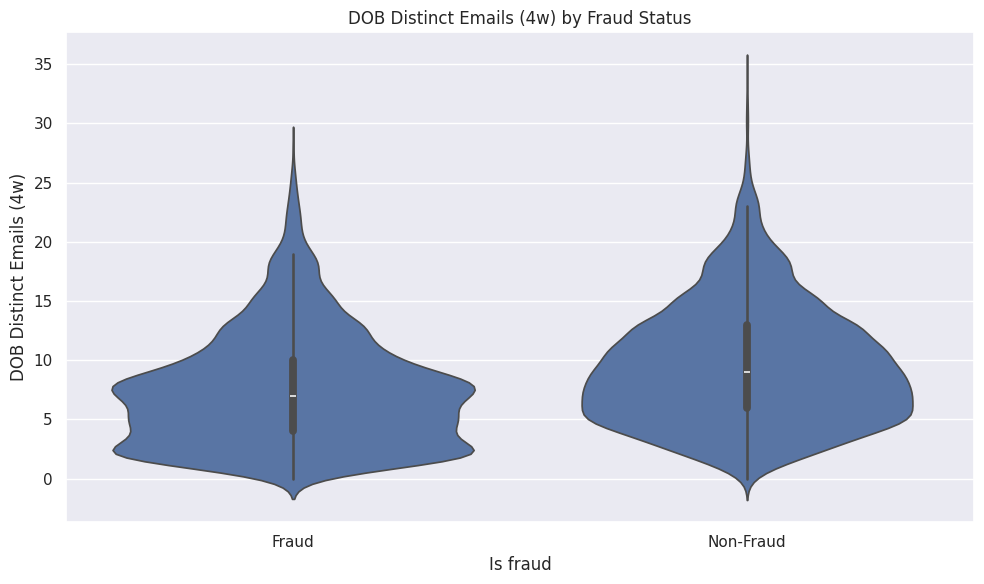

In [77]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="date_of_birth_distinct_emails_4w")
plt.title("DOB Distinct Emails (4w) by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("DOB Distinct Emails (4w)")
plt.tight_layout()
plt.savefig(FIG_PATH / "dob_distinct_emails_by_fraud_status.png")
plt.show()

Non fraudulent accounts have a higher mean. Fraudulent accounts might create accounts in bulk and avoid same date of birth? 

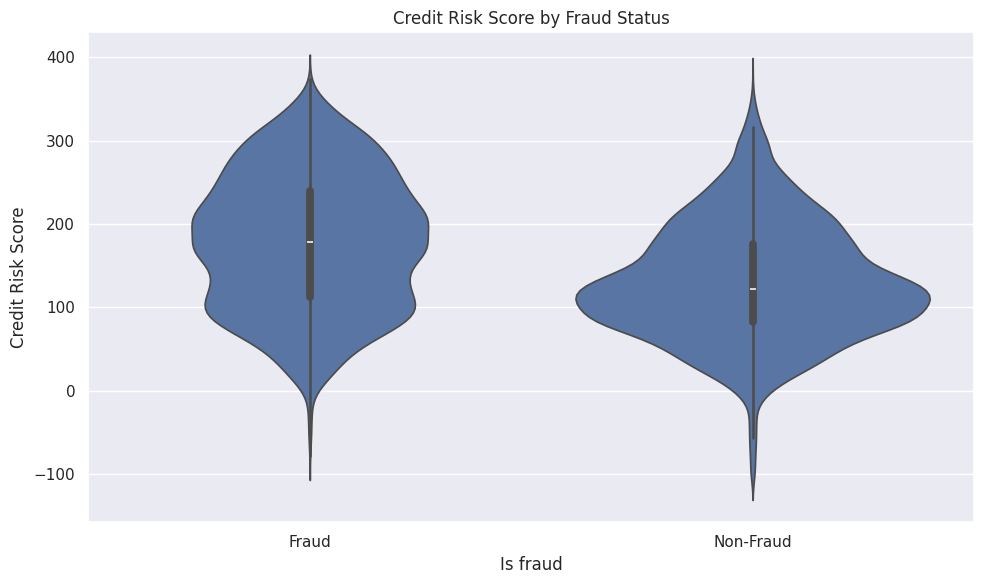

In [78]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="credit_risk_score")
plt.title("Credit Risk Score by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Credit Risk Score")
plt.tight_layout()
plt.savefig(FIG_PATH / "credit_risk_score_by_fraud_status.png")
plt.show()

Fraudulent accounts have a slightly higher mean credit risk score

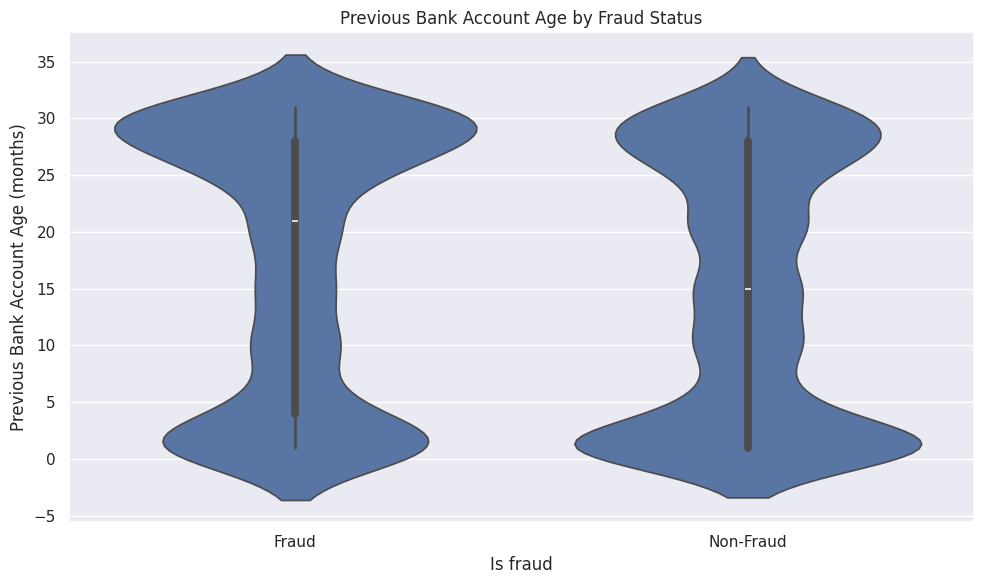

In [79]:
plt.figure(figsize=(10, 6))
positive_bank_months = sampled_dataset[sampled_dataset['bank_months_count'] >= 0]
sns.violinplot(positive_bank_months, x="fraud_bool", y="bank_months_count")
plt.title("Previous Bank Account Age by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Previous Bank Account Age (months)")
plt.tight_layout()
plt.savefig(FIG_PATH / "bank_months_by_fraud_status.png")
plt.show()

Mean previous bank account age is higher for fraudulent accounts. The data distribution is almost the same.

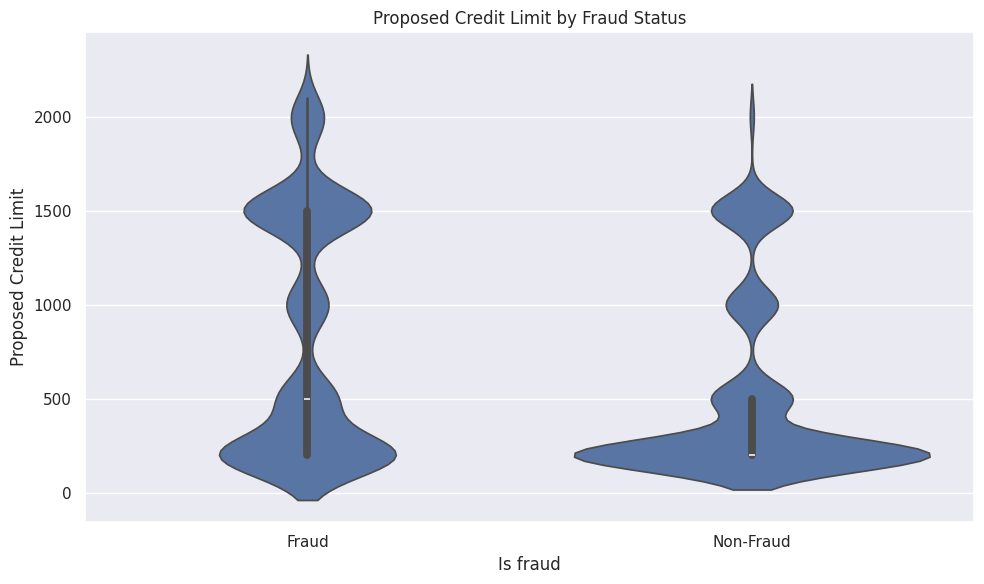

In [80]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="proposed_credit_limit")
plt.title("Proposed Credit Limit by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Proposed Credit Limit")
plt.tight_layout()
plt.savefig(FIG_PATH / "proposed_credit_limit_by_fraud_status.png")
plt.show()

Fraudulent accounts tend to request higher credit limits than common accounts

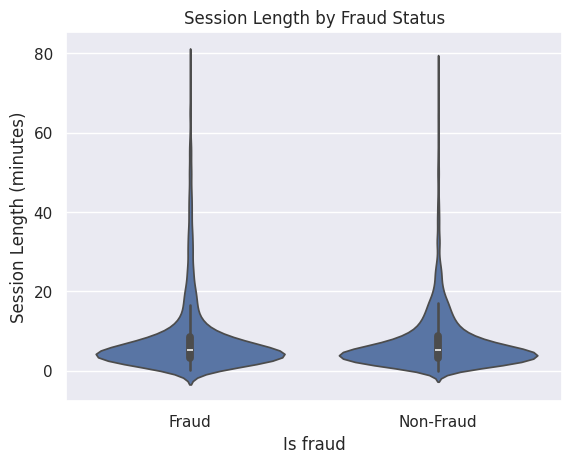

In [81]:
positive_session = sampled_dataset[sampled_dataset['session_length_in_minutes'] >= 0]
sns.violinplot(positive_session, x="fraud_bool", y="session_length_in_minutes")
plt.title("Session Length by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Session Length (minutes)")
plt.show()

Same mean and distribution

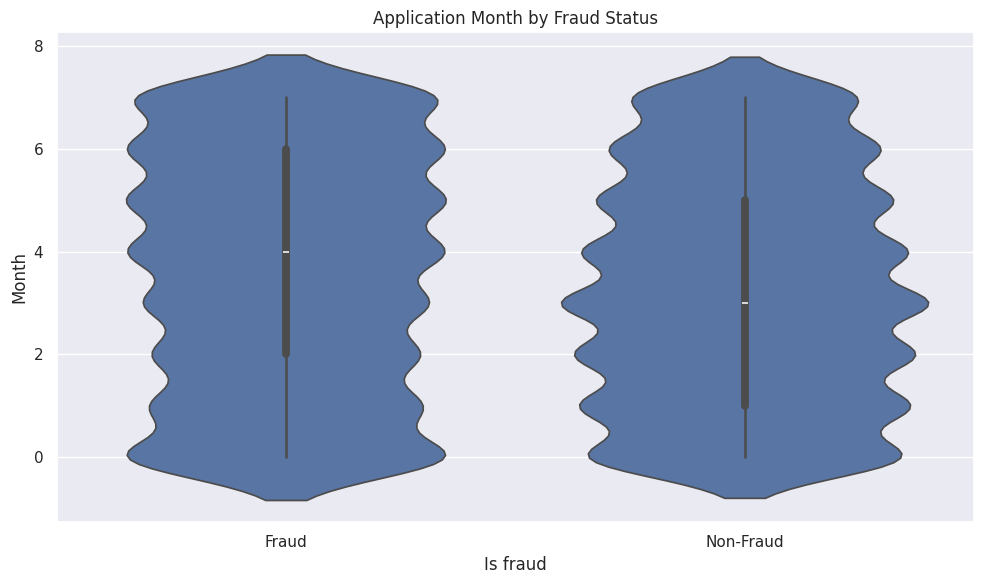

In [82]:
plt.figure(figsize=(10, 6))
sns.violinplot(sampled_dataset, x="fraud_bool", y="month")
plt.title("Application Month by Fraud Status")
plt.xlabel("Is fraud")
plt.ylabel("Month")
plt.tight_layout()
plt.savefig(FIG_PATH / "application_month_by_fraud_status.png")
plt.show()

Non fraudulent accounts appear to request accounts slightly earlier in the year

### Fraudulent vs Non Fraudulent Categorical Groups 

In [83]:
def calculate_percentage(n1, n2):
    total = n1 + n2
    pct_n1 = n1 / total
    pct_n2 = n2 / total
    return pct_n1, pct_n2

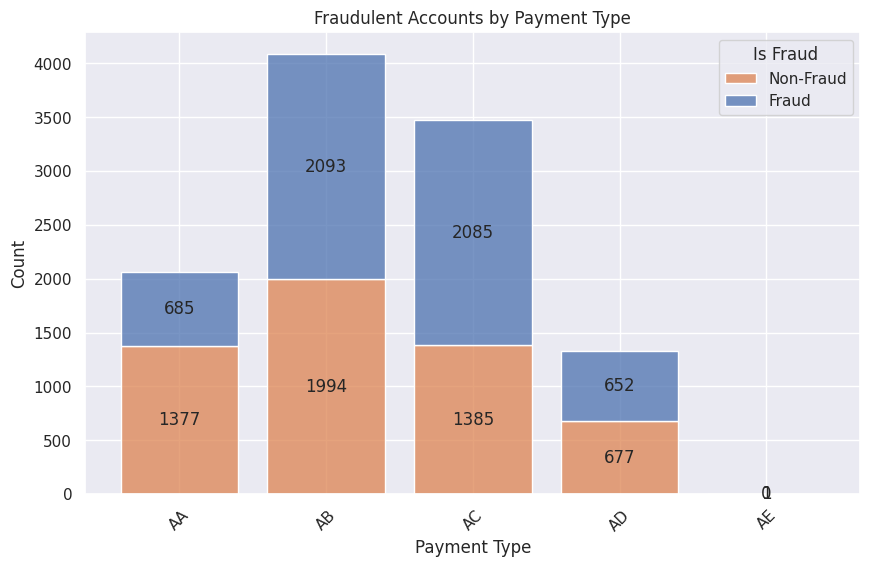

In [84]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sampled_dataset, x='payment_type', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Payment Type')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Payment Type')
plt.xticks(rotation=45)
plt.show()

AB and AC have more fraudulent accounts. AA have way less fraudulent accounts. AE have small sample size.

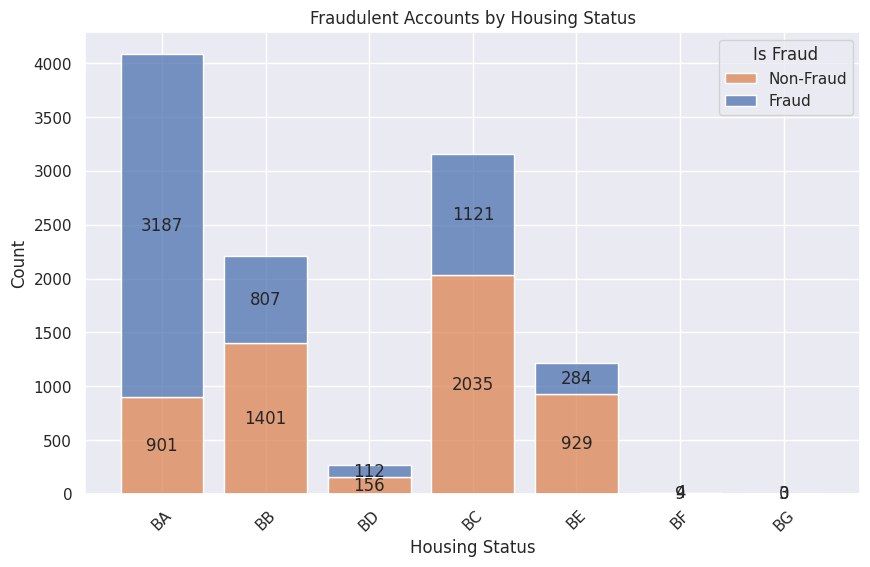

In [85]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sampled_dataset, x='housing_status', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Housing Status')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Housing Status')
plt.xticks(rotation=45)
plt.show()

BA is noticeably the most used housing status in fraudulent account creation requests. BB, BC, BE and BD all have more common account creation requests than fraudulent ones. BF and BG don't have a good sample size.

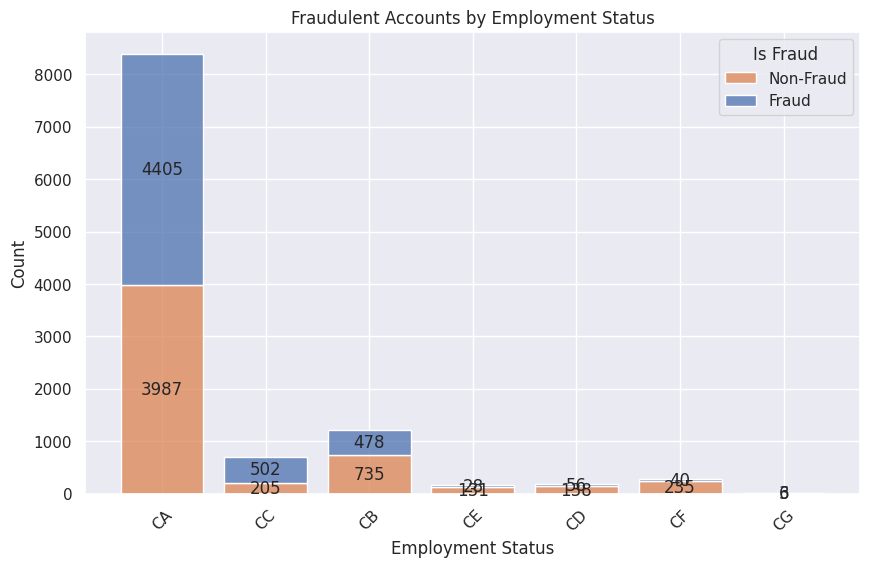

In [86]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sampled_dataset, x='employment_status', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Employment Status')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Employment Status')
plt.xticks(rotation=45)
plt.show()

CA is the most used employment status for both common accounts and fraudulent ones. Among the accounts using CA employment status, more than half are fraudulent. CC is another common choice by fraudulent accounts. CG has a small sample size

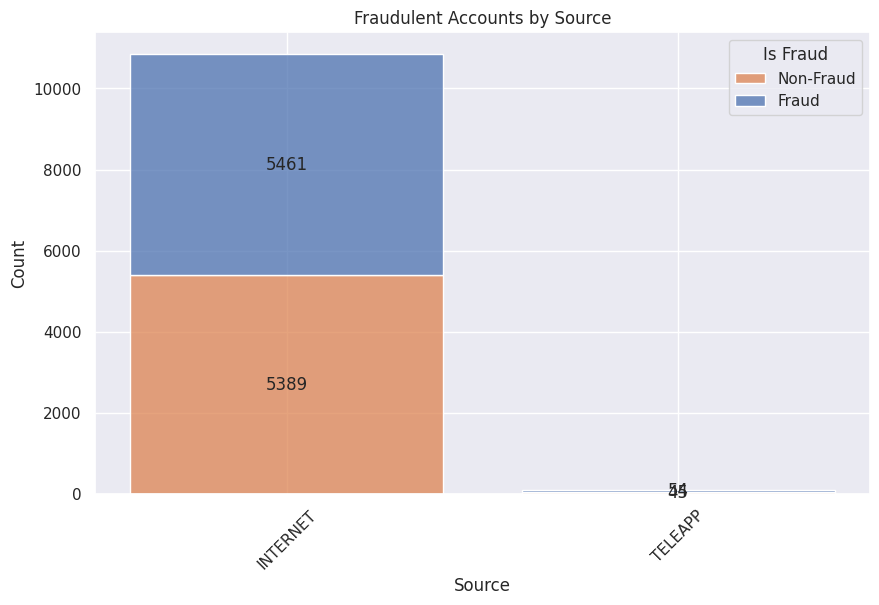

In [87]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sampled_dataset, x='source', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Source')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Source')
plt.xticks(rotation=45)
plt.show()

Classes are extremely unbalanced, as noticed before.

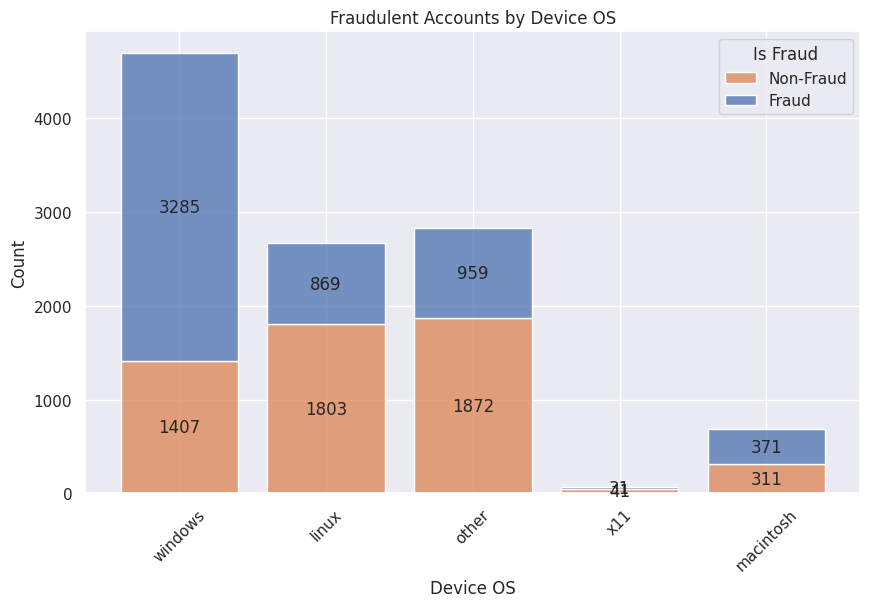

In [88]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sampled_dataset, x='device_os', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Device OS')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Device OS')
plt.xticks(rotation=45)
plt.show()

In [89]:
print("Windows:")
print(calculate_percentage(3330, 1452))

print("Other:")
print(calculate_percentage(963, 1977))

print("Linux:")
print(calculate_percentage(843, 1825))

Windows:
(0.6963613550815558, 0.30363864491844417)
Other:
(0.32755102040816325, 0.6724489795918367)
Linux:
(0.3159670164917541, 0.6840329835082459)


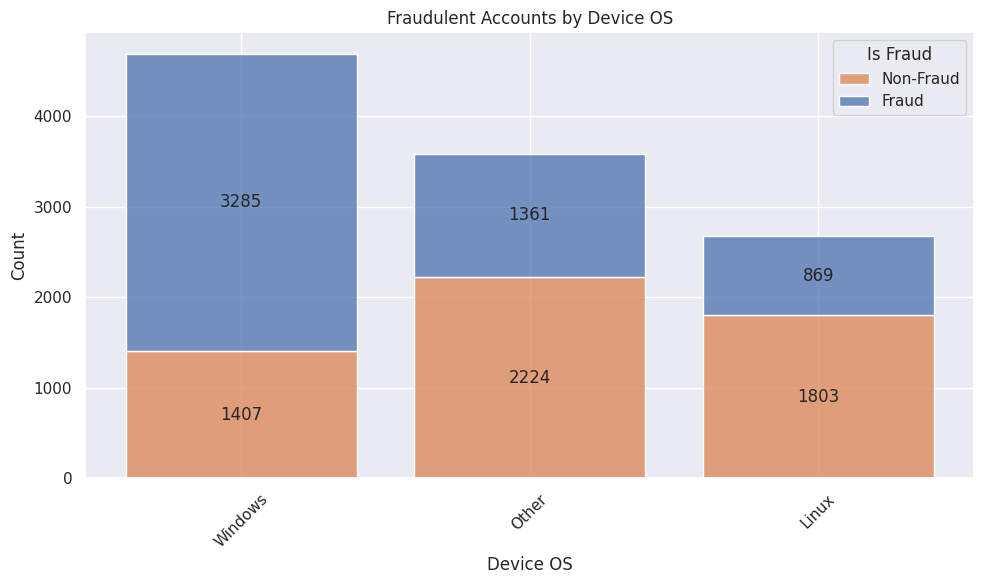

In [90]:
device_os_df = sampled_dataset.copy()
device_os_df['device_os'] = device_os_df['device_os'].replace({
    'windows': 'Windows',
    'other': 'Other',
    'linux': 'Linux',
    'macintosh': 'Other',
    "x11": "Other"
})
# sorts by device_os based on device_os value counts
device_os_df['device_os'] = pd.Categorical(device_os_df['device_os'], 
                                             categories=device_os_df['device_os'].value_counts().index, 
                                             ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=device_os_df, x='device_os', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Device OS')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Device OS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIG_PATH / "fraudulent_accounts_by_device_os.png")
plt.show()

Number of windows users is the biggest, while in the previous distribution analysis the "other" device OS was the biggest, followed by windows. Therefore the distribution of this sample is not quite representative of the complete dataset. This might have been caused by the attempt to balance the classes.

Approximately 70% of the accounts requested through a windows OS were fraudulent. Only 1 third of the accounts requests through other OSs were fraudulent. Only 1 third of linux requests were fraudulent.

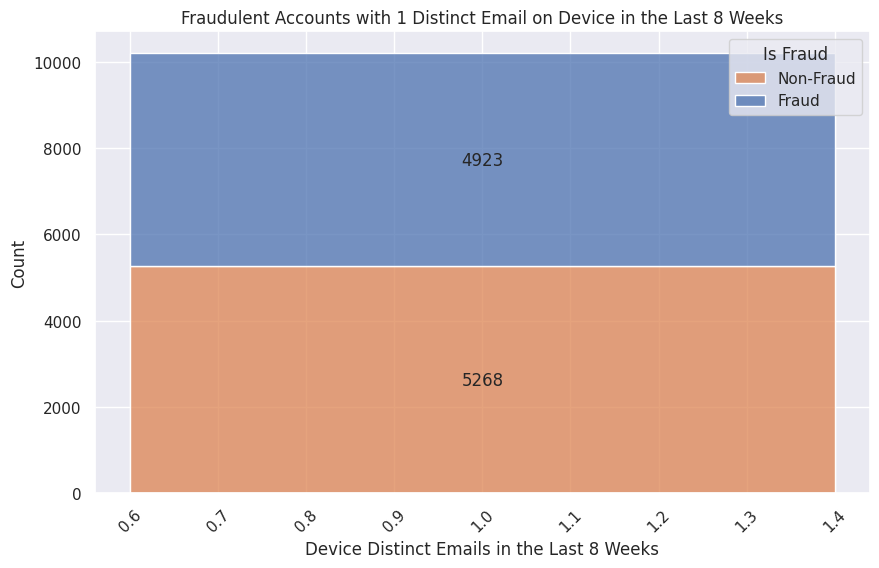

In [91]:
plt.figure(figsize=(10, 6))
one_or_more_email = sampled_dataset[sampled_dataset['device_distinct_emails_8w'] == 1]
ax = sns.histplot(data=one_or_more_email, x='device_distinct_emails_8w', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts with 1 Distinct Email on Device in the Last 8 Weeks')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Device Distinct Emails in the Last 8 Weeks')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_514935/1712081456.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/tmp/ipykernel_514935/1712081456.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



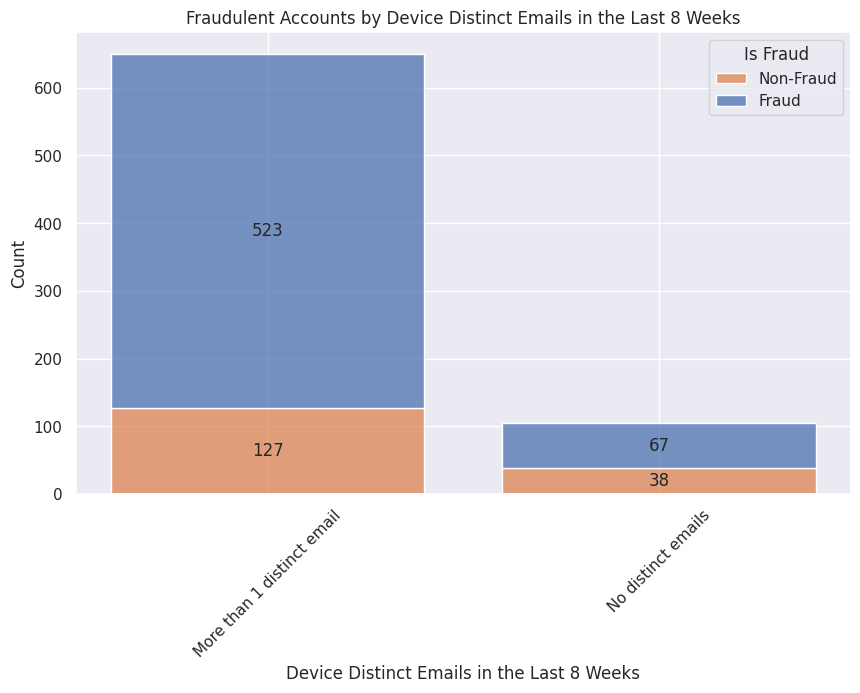

In [92]:
plt.figure(figsize=(10, 6))
positive_device_emails = sampled_dataset[sampled_dataset['device_distinct_emails_8w'] >= 0]
more_or_less_than_one_email = positive_device_emails[sampled_dataset['device_distinct_emails_8w'] != 1]
# remaps column device_distinct_emails_8w to two classes: 1 and more than 1
more_or_less_than_one_email['device_distinct_emails_8w'] = more_or_less_than_one_email['device_distinct_emails_8w'].apply(lambda x: 'No distinct emails' if x == 0 else 'More than 1 distinct email')
ax = sns.histplot(data=more_or_less_than_one_email, x='device_distinct_emails_8w', hue='fraud_bool', multiple='stack', 
                  discrete=True, shrink=0.8)

for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%g')
plt.title('Fraudulent Accounts by Device Distinct Emails in the Last 8 Weeks')
plt.legend(title='Is Fraud', loc='upper right',labels=['Non-Fraud', 'Fraud'])
plt.xlabel('Device Distinct Emails in the Last 8 Weeks')
plt.xticks(rotation=45)
plt.show()

In [93]:
print("More than 1 distinct email:")
print(calculate_percentage(529, 140))
print()

print("No distinct email:")
print(calculate_percentage(78, 38))

More than 1 distinct email:
(0.7907324364723468, 0.20926756352765322)

No distinct email:
(0.6724137931034483, 0.3275862068965517)


As expected, having no distinct emails in the past 8 weeks or have more than a single distinct email are possibily an indicator or fraudulent accounts. No dinstinct emails on the same device probably means the user tried to create multiple accounts in the past 8 weeks with the same email, while having 2 or more distinct emails means the user probably tried to use the same device to create multiple fraudulent accounts.